In [1]:
from parameters import parameters
from pcnn.util import load_data
from pcnn.model import Model

# Load data, define interval
data = load_data('umar')
interval = 15

display(data.head())

data.columns

,Solar irradiation,Outside temperature,Temperature 272,Temperature 273,Temperature 274,Month sin,Month cos,Weekday,Timestep sin,Timestep cos,Power 272,Power 273,Power 274,Case
2019-05-01 00:00:00,0.0,7.877023,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.000000,1.000000,0.0,0.0,0.0,1.0
2019-05-01 00:15:00,0.0,7.631382,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.065403,0.997859,0.0,0.0,0.0,1.0
2019-05-01 00:30:00,0.0,7.527863,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.130526,0.991445,0.0,0.0,0.0,1.0
2019-05-01 00:45:00,0.0,7.343938,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.195090,0.980785,0.0,0.0,0.0,1.0
2019-05-01 01:00:00,0.0,7.193133,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.258819,0.965926,0.0,0.0,0.0,1.0


Index(['Solar irradiation', 'Outside temperature', 'Temperature 272',
       'Temperature 273', 'Temperature 274', 'Month sin', 'Month cos',
       'Weekday', 'Timestep sin', 'Timestep cos', 'Power 272', 'Power 273',
       'Power 274', 'Case'],
      dtype='object')

In [2]:
model_kwargs = parameters(unit='UMAR',
                            to_normalize=True,
                            name="S-PCNN",
                            seed=0,
                            overlapping_distance=4,
                            warm_start_length=12,
                            maximum_sequence_length=96*3,
                            minimum_sequence_length=48,
                            learn_initial_hidden_states=True,
                            decrease_learning_rate=False,
                            learning_rate=0.0005,
                            feed_input_through_nn=True,
                            input_nn_hidden_sizes=[32],
                            lstm_hidden_size=64,
                            lstm_num_layers=2,
                            layer_norm=True,
                            batch_size=256,
                            output_nn_hidden_sizes=[32],
                            division_factor=10.,
                            verbose=2)

module = 'S_PCNN'
rooms = ['272', '273', '274']

# No need of info on room 274 as input
X_columns = ['Solar irradiation', 'Outside temperature', 'Temperature 272', 'Temperature 273', 'Temperature 274', 'Month sin', 'Month cos',
            'Weekday', 'Timestep sin', 'Timestep cos', 'Power 272', 'Power 273', 'Power 274', 'Case']
Y_columns = ['Temperature 272', 'Temperature 273', 'Temperature 274']

# Corresponding columns
case_column = -1
out_column = 1
neigh_column = None # Not needed in S-PCNNs
temperature_column = [2, 3, 4]
power_column = [-4, -3, -2] # Ensure same order as the temperatures and rooms

# Info to use in D
inputs_D = [0, 5, 6, 7, 8, 9]

topology = {'Rooms': rooms,
            'Outside': [0, 1, 2], # Which rooms have an external wal
            'Neighbors': [(0,1), (1,2)]} # Which rooms are connected

# Trying to load a model or not, if yes the last one or the best one
load = True
load_last = False

s_pcnn = Model(data=data, interval=interval, model_kwargs=model_kwargs, inputs_D=inputs_D, 
            module=module, rooms=rooms, case_column=case_column, out_column=out_column, neigh_column=neigh_column, 
            temperature_column=temperature_column, power_column=power_column,
            Y_columns=Y_columns, X_columns=X_columns, topology=topology, load_last=load_last,
            load=load)



Preparing the data...
Normalizing the data...
Data ready!

Sanity check of the columns:
 [('Case', ['Case']), ('Room temp', ['Temperature 272', 'Temperature 273', 'Temperature 274']), ('Room power', ['Power 272', 'Power 273', 'Power 274']), ('Out temp', ['Outside temperature'])]
Inputs used in D:
 ['Solar irradiation' 'Month sin' 'Month cos' 'Weekday' 'Timestep sin'
 'Timestep cos']

Trying to load a trained model...
Found!
The model has been fitted for 112 epochs already, with loss  0.00243.
It contains 8822 training sequences and 2381 validation sequences.



In [3]:
train = False
if train:
    s_pcnn.fit(100)

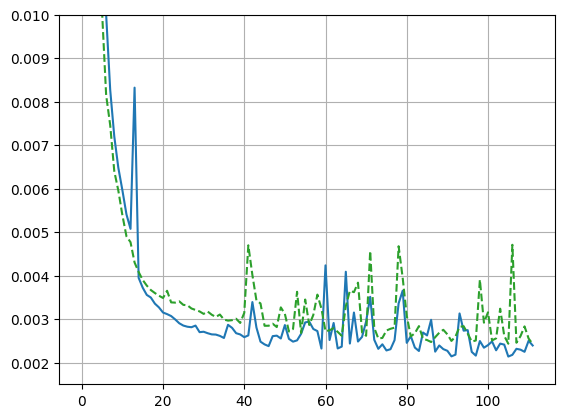

In [4]:
import matplotlib.pyplot as plt
plt.plot(s_pcnn.train_losses, c='tab:blue')
plt.plot(s_pcnn.validation_losses, c='tab:green', ls='--')
plt.ylim(0.0015, 0.01)
plt.grid()